In [65]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
import nltk
import itertools
from nltk import WordNetLemmatizer, pos_tag 
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, sent_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
import matplotlib.pyplot as plt
import string
import re
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aheinke/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/aheinke/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# Pulling in our dataset with reviews on dating apps, downloaded from Kaggle
dating_df = pd.read_csv('/Users/aheinke/Downloads/DatingAppReviewsDataset.csv').drop(columns = ['Unnamed: 0'])
dating_df

,Unnamed: 0,Name,Review,Rating,#ThumbsUp,Date&Time,App
0,0,linah sibanda,On this app i cant find a partner,5,0,18-02-2022 01:19,Tinder
1,1,Norman Johnson,Tinder would be so much better if we could spe...,3,0,18-02-2022 01:16,Tinder
2,2,David Hume,Still doesn't correctly notify matches or mess...,1,0,18-02-2022 01:11,Tinder
3,3,Last 1 Standing,"Got banned because I updated my bio to say ""I ...",2,0,18-02-2022 01:11,Tinder
4,4,Arthur Magamedov,Love it!,5,0,18-02-2022 01:06,Tinder
...,...,...,...,...,...,...,...
681989,52989,A Google user,Useless - I'm in the UK and it tells me i'm ov...,2,5,12-07-2017 01:44,Hinge
681990,52990,Brian Shook,I can't get past the initial set up. It won't...,1,11,12-07-2017 01:36,Hinge
681991,52991,A Google user,This is incredible! A quality dating app for A...,5,1,12-07-2017 01:32,Hinge
681992,52992,A Google user,"""Over Water"" ... Can't choose location.",2,8,12-07-2017 01:28,Hinge


In [5]:
# Checking for how many entries we have for each rating
dating_df['Rating'].value_counts()

1    251969
5    233464
4     87347
3     56958
2     52255
0         1
Name: Rating, dtype: int64

Text(0.5, 1.0, 'App Rating')

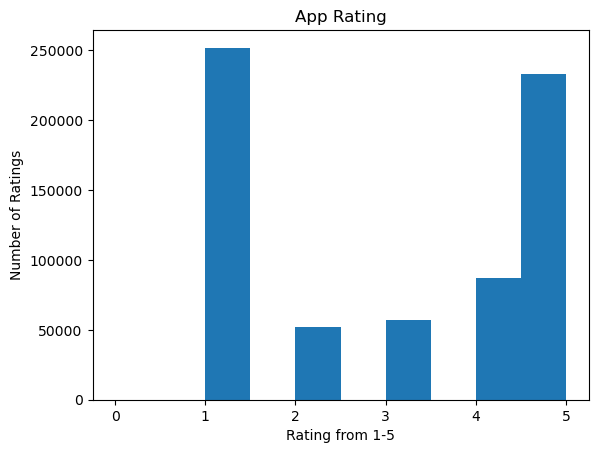

In [6]:
plt.hist(dating_df['Rating'])
plt.xlabel('Rating from 1-5')
plt.ylabel('Number of Ratings')
plt.title('App Rating')

In [7]:
dating_df['App'].value_counts()

Tinder    526616
Bumble    102384
Hinge      52994
Name: App, dtype: int64

In [8]:
app_ratings2 = dating_df.groupby(['App', 'Rating'])['Rating'].count()
app_ratings2

App     Rating
Bumble  1          40412
        2           9674
        3           8841
        4          13589
        5          29868
Hinge   1          15920
        2           4509
        3           5289
        4           8617
        5          18659
Tinder  0              1
        1         195637
        2          38072
        3          42828
        4          65141
        5         184937
Name: Rating, dtype: int64

In [9]:
# Looking at the datatypes of each of our columns and checking for any null values
dating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681994 entries, 0 to 681993
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  681994 non-null  int64 
 1   Name        681989 non-null  object
 2   Review      680642 non-null  object
 3   Rating      681994 non-null  int64 
 4   #ThumbsUp   681994 non-null  int64 
 5   Date&Time   681994 non-null  object
 6   App         681994 non-null  object
dtypes: int64(3), object(4)
memory usage: 36.4+ MB


In [10]:
# Changing the contents in our 'Review' column from objects to strings
dating_df['Review'] = dating_df['Review'].astype(str)

In [11]:
dating_df['Review'].str.split(',')

0                       [On this app i cant find a partner]
1         [Tinder would be so much better if we could sp...
2         [Still doesn't correctly notify matches or mes...
3         [Got banned because I updated my bio to say "I...
4                                                [Love it!]
                                ...                        
681989    [Useless - I'm in the UK and it tells me i'm o...
681990    [I can't get past the initial set up.  It won'...
681991    [This is incredible! A quality dating app for ...
681992            ["Over Water" ... Can't choose location.]
681993    [My entire town counts as "over water" and I c...
Name: Review, Length: 681994, dtype: object

In [12]:
# Verifying that our 'Review' column now includes strings
print(set(type(x) for x in dating_df['Review']))

{<class 'str'>}


In [63]:
# Taking a look at the text of one of the reviews (expecting some to be pretty funny)
dating_df['Review'][2]

"Still doesn't correctly notify matches or messages. It's a monopoly so expect zero improvement in functionality. Overpriced. The recently added features like date night ask infantile and western culture based questions. Western dating culture is pure evil. The marketing tactics are designed to manipulate and extract money from men and while hiding how the app works. An evil company enabled by unregulated capitalism/psychopathy."

In [14]:
# Tokenizing the text in the 'Review' column of our dataset 
corpus = [word_tokenize(doc) for doc in dating_df['Review']]
print(corpus[0:4])

[['On', 'this', 'app', 'i', 'cant', 'find', 'a', 'partner'], ['Tinder', 'would', 'be', 'so', 'much', 'better', 'if', 'we', 'could', 'specify', 'the', 'race', 'that', 'we', 'are', 'looking', 'for', 'instead', 'of', 'swiping', 'unnecessarily', 'though', 'EVERYONE'], ['Still', 'does', "n't", 'correctly', 'notify', 'matches', 'or', 'messages', '.', 'It', "'s", 'a', 'monopoly', 'so', 'expect', 'zero', 'improvement', 'in', 'functionality', '.', 'Overpriced', '.', 'The', 'recently', 'added', 'features', 'like', 'date', 'night', 'ask', 'infantile', 'and', 'western', 'culture', 'based', 'questions', '.', 'Western', 'dating', 'culture', 'is', 'pure', 'evil', '.', 'The', 'marketing', 'tactics', 'are', 'designed', 'to', 'manipulate', 'and', 'extract', 'money', 'from', 'men', 'and', 'while', 'hiding', 'how', 'the', 'app', 'works', '.', 'An', 'evil', 'company', 'enabled', 'by', 'unregulated', 'capitalism/psychopathy', '.'], ['Got', 'banned', 'because', 'I', 'updated', 'my', 'bio', 'to', 'say', '``',

In [15]:
# Flattening our corpus for a better understanding of what it entails
flattenedcorpus_tokens = pd.Series(list(itertools.chain(*corpus)))
print(flattenedcorpus_tokens.shape)

(12844301,)


In [16]:
# Getting a count of the amount of unique words/characters in our corpus
dictionary = pd.Series(
    flattenedcorpus_tokens.unique())
print(len(dictionary))

143861


In [17]:
# Looking at the value counts of those words/characters
# Definitely have some mis-spelled words, acronyms...a number of things that we will most likely be dropping
flattenedcorpus_tokens.value_counts()

.             609596
I             350851
to            342230
the           274477
,             253732
               ...  
protet             1
card.there         1
sitea1             1
nunbers            1
wya                1
Length: 143861, dtype: int64

In [18]:
# Looking at the top 30 of our flattened corpus
flattenedcorpus_tokens.value_counts()[0:30]

.         609596
I         350851
to        342230
the       274477
,         253732
and       250831
a         223815
app       221466
it        218555
n't       151779
you       142716
of        136740
for       135470
is        134807
!         114409
my        112080
in        100812
this       91801
's         89319
me         88834
have       88167
but        87311
on         87186
not        87038
that       83603
people     73400
with       72329
It         63321
do         60447
get        57308
dtype: int64

In [19]:
flattenedcorpus_tokens.isin(['dating']).sum()

25440

In [20]:
flattenedcorpus_tokens.isin(['Dating']).sum()

879

In [21]:
flattenedcorpus_tokens.isin(['date']).sum()

5743

In [22]:
flattenedcorpus_tokens.isin(['Date']).sum()

118

In [23]:
# Looking at the tokens with one occurenece in the corpus
num_one_occurence = (flattenedcorpus_tokens.
                     value_counts() == 1).sum()
num_one_occurence

91176

In [24]:
# Have quite a few numeric tokens that we also won't need
dictionary[dictionary.str.isnumeric()]

243           18
263            5
451            2
466           24
511          286
           ...  
142326      1983
142827       235
143458      1975
143474    140000
143801      8122
Length: 809, dtype: object

In [25]:
# Instantiating stopwords
stop_words = stopwords.words('english')
print(stop_words[0:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [26]:
# Looping through our corpus to remove stopwords and lowercase the leftover tokens
def first_step_normalizer(doc):
    norm_text = [x.lower() for x in word_tokenize(doc) if ((x.isalpha()) & (x not in stop_words)) ]
    return norm_text

In [27]:
# Creating a new column with our normalized reviews
dating_df['Review_norm'] = dating_df['Review'].apply(first_step_normalizer)
dating_df.head()

,Unnamed: 0,Name,Review,Rating,#ThumbsUp,Date&Time,App,Review_norm
0,0,linah sibanda,On this app i cant find a partner,5,0,18-02-2022 01:19,Tinder,"[on, app, cant, find, partner]"
1,1,Norman Johnson,Tinder would be so much better if we could spe...,3,0,18-02-2022 01:16,Tinder,"[tinder, would, much, better, could, specify, ..."
2,2,David Hume,Still doesn't correctly notify matches or mess...,1,0,18-02-2022 01:11,Tinder,"[still, correctly, notify, matches, messages, ..."
3,3,Last 1 Standing,"Got banned because I updated my bio to say ""I ...",2,0,18-02-2022 01:11,Tinder,"[got, banned, i, updated, bio, say, i, feel, l..."
4,4,Arthur Magamedov,Love it!,5,0,18-02-2022 01:06,Tinder,[love]


In [28]:
# Taking a look at that same review from earlier after it has been normalized
print(dating_df['Review_norm'].iloc[2])

['still', 'correctly', 'notify', 'matches', 'messages', 'it', 'monopoly', 'expect', 'zero', 'improvement', 'functionality', 'overpriced', 'the', 'recently', 'added', 'features', 'like', 'date', 'night', 'ask', 'infantile', 'western', 'culture', 'based', 'questions', 'western', 'dating', 'culture', 'pure', 'evil', 'the', 'marketing', 'tactics', 'designed', 'manipulate', 'extract', 'money', 'men', 'hiding', 'app', 'works', 'an', 'evil', 'company', 'enabled', 'unregulated']


In [29]:
# Checking the amount of unique tokens after removing stopwords.
# We initally had 143,861
norm_toks_flattened = pd.Series(list(
    itertools.chain(*dating_df['Review_norm'])))
new_dictionary = norm_toks_flattened.unique()
print(len(new_dictionary))

85187


In [30]:
# Instantiating our stemmers
p_stemmer = PorterStemmer()
s_stemmer = SnowballStemmer(language = 'english')
l_stemmer = LancasterStemmer()

In [31]:
# Setting a sample review to test our stemmers/lemmatizers with
sample_rev = dating_df['Review_norm'].iloc[2]
print(sample_rev)

['still', 'correctly', 'notify', 'matches', 'messages', 'it', 'monopoly', 'expect', 'zero', 'improvement', 'functionality', 'overpriced', 'the', 'recently', 'added', 'features', 'like', 'date', 'night', 'ask', 'infantile', 'western', 'culture', 'based', 'questions', 'western', 'dating', 'culture', 'pure', 'evil', 'the', 'marketing', 'tactics', 'designed', 'manipulate', 'extract', 'money', 'men', 'hiding', 'app', 'works', 'an', 'evil', 'company', 'enabled', 'unregulated']


In [32]:
# Trying out the snowball stemmer
snowball_stemmed_rev  = [s_stemmer.stem(token) 
                     for token in sample_rev]
print(snowball_stemmed_rev)

['still', 'correct', 'notifi', 'match', 'messag', 'it', 'monopoli', 'expect', 'zero', 'improv', 'function', 'overpr', 'the', 'recent', 'ad', 'featur', 'like', 'date', 'night', 'ask', 'infantil', 'western', 'cultur', 'base', 'question', 'western', 'date', 'cultur', 'pure', 'evil', 'the', 'market', 'tactic', 'design', 'manipul', 'extract', 'money', 'men', 'hide', 'app', 'work', 'an', 'evil', 'compani', 'enabl', 'unregul']


In [33]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/aheinke/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/aheinke/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/aheinke/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [34]:
# Looking at the POS tagging of our sample
pos_tag(sample_rev)

[('still', 'RB'),
 ('correctly', 'RB'),
 ('notify', 'JJ'),
 ('matches', 'NNS'),
 ('messages', 'NNS'),
 ('it', 'PRP'),
 ('monopoly', 'JJ'),
 ('expect', 'JJ'),
 ('zero', 'NN'),
 ('improvement', 'NN'),
 ('functionality', 'NN'),
 ('overpriced', 'VBD'),
 ('the', 'DT'),
 ('recently', 'RB'),
 ('added', 'VBD'),
 ('features', 'NNS'),
 ('like', 'IN'),
 ('date', 'NN'),
 ('night', 'NN'),
 ('ask', 'NN'),
 ('infantile', 'NN'),
 ('western', 'JJ'),
 ('culture', 'NN'),
 ('based', 'VBN'),
 ('questions', 'NNS'),
 ('western', 'JJ'),
 ('dating', 'JJ'),
 ('culture', 'NN'),
 ('pure', 'NN'),
 ('evil', 'VBZ'),
 ('the', 'DT'),
 ('marketing', 'NN'),
 ('tactics', 'NNS'),
 ('designed', 'VBN'),
 ('manipulate', 'JJ'),
 ('extract', 'JJ'),
 ('money', 'NN'),
 ('men', 'NNS'),
 ('hiding', 'VBG'),
 ('app', 'NN'),
 ('works', 'VBZ'),
 ('an', 'DT'),
 ('evil', 'JJ'),
 ('company', 'NN'),
 ('enabled', 'VBD'),
 ('unregulated', 'JJ')]

In [35]:
# Helper function to change nltk's part of speech tagging to a wordnet format
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None

In [36]:
# Creates list of tokens with Wordnet format
wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(sample_rev))) 
print(wordnet_tagged)

[('still', 'r'), ('correctly', 'r'), ('notify', 'a'), ('matches', 'n'), ('messages', 'n'), ('it', None), ('monopoly', 'a'), ('expect', 'a'), ('zero', 'n'), ('improvement', 'n'), ('functionality', 'n'), ('overpriced', 'v'), ('the', None), ('recently', 'r'), ('added', 'v'), ('features', 'n'), ('like', None), ('date', 'n'), ('night', 'n'), ('ask', 'n'), ('infantile', 'n'), ('western', 'a'), ('culture', 'n'), ('based', 'v'), ('questions', 'n'), ('western', 'a'), ('dating', 'a'), ('culture', 'n'), ('pure', 'n'), ('evil', 'v'), ('the', None), ('marketing', 'n'), ('tactics', 'n'), ('designed', 'v'), ('manipulate', 'a'), ('extract', 'a'), ('money', 'n'), ('men', 'n'), ('hiding', 'v'), ('app', 'n'), ('works', 'v'), ('an', None), ('evil', 'a'), ('company', 'n'), ('enabled', 'v'), ('unregulated', 'a')]


In [37]:
# Instantiating our Wordnet lemmatizer
wnl = WordNetLemmatizer()
rev_lemmatized = [wnl.lemmatize(token, pos) for token, pos in wordnet_tagged if pos is not None]
print(rev_lemmatized)

['still', 'correctly', 'notify', 'match', 'message', 'monopoly', 'expect', 'zero', 'improvement', 'functionality', 'overprice', 'recently', 'add', 'feature', 'date', 'night', 'ask', 'infantile', 'western', 'culture', 'base', 'question', 'western', 'dating', 'culture', 'pure', 'evil', 'marketing', 'tactic', 'design', 'manipulate', 'extract', 'money', 'men', 'hide', 'app', 'work', 'evil', 'company', 'enable', 'unregulated']


In [38]:
# Prefer what our Wordnet Lemmatizer returns, so we are going to apply this to our corpus
# Takes in untokenized document and returns fully normalized token list
def process_rev(rev):

    wnl = WordNetLemmatizer()


    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
        
    review_norm = [tok.lower() for tok in word_tokenize(rev) if ((tok.isalpha()) & (tok not in stop_words)) ]
    
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(review_norm))) 
    review_norm = [wnl.lemmatize(token, pos) for token, pos in wordnet_tagged if pos is not None]
    
    return review_norm

In [39]:
# Applying the code above to our Review column
fully_normalized_corpus = dating_df['Review'].apply(process_rev)

In [40]:
fully_normalized_corpus.head()

0                           [app, cant, find, partner]
1    [tinder, much, better, specify, race, look, in...
2    [still, correctly, notify, match, message, mon...
3    [get, ban, i, updated, bio, say, i, feel, girl...
4                                               [love]
Name: Review, dtype: object

In [41]:
flattened_fully_norm = pd.Series(list(itertools.chain(*fully_normalized_corpus)))
len(flattened_fully_norm.unique())

78067

In [42]:
flattened_fully_norm.value_counts()[0:30]

i          349643
app        226859
get        105209
good        87336
match       79310
people      76090
use         66263
tinder      62204
time        55414
great       45256
account     45115
work        44952
pay         44783
profile     43867
even        43829
message     40350
try         38664
log         35514
make        34582
like        33532
say         33218
ban         32324
go          32040
date        32002
see         30488
nice        30026
meet        28069
new         27992
swipe       27174
money       26935
dtype: int64

In [43]:
flattened_fully_norm.value_counts().tail(30)

impotency       1
forcedly        1
uttterly        1
unity           1
createnew       1
bloemfontein    1
withmy          1
interviewto     1
randamly        1
lendy           1
chiste          1
etna            1
pigheaded       1
iclude          1
mojjaaa         1
subnormales     1
encontrarán     1
ahad            1
sinceros        1
muchachos       1
vrsn            1
agreeing        1
thougn          1
jjg             1
inagain         1
vvvbn           1
creap           1
courpse         1
guid            1
wya             1
dtype: int64

In [44]:
flattened_fully_norm_value_counts = flattened_fully_norm.value_counts()
count_of_single_occurrences = (flattened_fully_norm_value_counts == 1).sum()
print(count_of_single_occurrences)

46495


In [45]:
# Checking the 200 mmost frequent words
freqdist = FreqDist(flattened_fully_norm)
 
most_common = freqdist.most_common(200)

In [46]:
# Turning our preprocessed data into a csv
fnc_output = fully_normalized_corpus.apply(" ".join)

fnc_output.to_csv('/Users/aheinke/Documents/Flatiron/phase-5-proj/dating_norm.csv')

In [47]:
fnc_output

0                                     app cant find partner
1         tinder much better specify race look instead s...
2         still correctly notify match message monopoly ...
3         get ban i updated bio say i feel girl look plu...
4                                                      love
                                ...                        
681989    useless i uk tell water let get run little tes...
681990    i get past initial set set neighborhood think ...
681991    incredible quality date app android boyfriend wya
681992                                water choose location
681993                    entire town count water i proceed
Name: Review, Length: 681994, dtype: object

In [48]:
# Pulling in our new dataset
corpus_df = pd.read_csv('/Users/aheinke/Documents/Flatiron/phase-5-proj/dating_norm.csv').drop(columns = ['Unnamed: 0'])
corpus_df

,Review
0,app cant find partner
1,tinder much better specify race look instead s...
2,still correctly notify match message monopoly ...
3,get ban i updated bio say i feel girl look plu...
4,love
...,...
681989,useless i uk tell water let get run little tes...
681990,i get past initial set set neighborhood think ...
681991,incredible quality date app android boyfriend wya
681992,water choose location


In [49]:
corpus_df['Review'].isnull().sum()

9996

In [50]:
corpus_df['Review'].fillna('', inplace = True)

In [51]:
# Convert our preprocessed strings (normalized token sequence) to a matrix of token counts
vec = CountVectorizer(min_df = 0.02, max_df = 0.98)
X = vec.fit_transform(corpus_df['Review'])

# .get_feature_names_out() useful attribute
countvec_df = pd.DataFrame(X.toarray(), columns = vec.get_feature_names_out())
countvec_df.head()

,account,also,app,apps,back,bad,ban,best,cool,date,...,tinder,try,update,use,want,waste,way,well,woman,work
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,2,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
#tf_vec = TfidfVectorizer()
#X_tfidf = tf_vec.fit_transform(corpus_df['Review'])

#vec_tfidf = pd.DataFrame(X_tfidf.toarray(), columns = tf_vec.get_feature_names_out())
#vec_tfidf.head()

In [53]:
#download vader from nltk
nltk.download('vader_lexicon')

#creating an object of sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/aheinke/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [54]:
#creating new column scores using polarity scores function
dating_df['scores'] = dating_df['Review'].apply(lambda body: sia.polarity_scores(str(body)))
dating_df.head()

,Unnamed: 0,Name,Review,Rating,#ThumbsUp,Date&Time,App,Review_norm,scores
0,0,linah sibanda,On this app i cant find a partner,5,0,18-02-2022 01:19,Tinder,"[on, app, cant, find, partner]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,1,Norman Johnson,Tinder would be so much better if we could spe...,3,0,18-02-2022 01:16,Tinder,"[tinder, would, much, better, could, specify, ...","{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'comp..."
2,2,David Hume,Still doesn't correctly notify matches or mess...,1,0,18-02-2022 01:11,Tinder,"[still, correctly, notify, matches, messages, ...","{'neg': 0.149, 'neu': 0.773, 'pos': 0.078, 'co..."
3,3,Last 1 Standing,"Got banned because I updated my bio to say ""I ...",2,0,18-02-2022 01:11,Tinder,"[got, banned, i, updated, bio, say, i, feel, l...","{'neg': 0.143, 'neu': 0.802, 'pos': 0.056, 'co..."
4,4,Arthur Magamedov,Love it!,5,0,18-02-2022 01:06,Tinder,[love],"{'neg': 0.0, 'neu': 0.182, 'pos': 0.818, 'comp..."


In [55]:
# Adding columns for compound, positive, negative, and neutral scores
dating_df['compound'] = dating_df['scores'].apply(lambda score_dict:score_dict['compound'])
dating_df['pos'] = dating_df['scores'].apply(lambda pos_dict:pos_dict['pos'])
dating_df['neg'] = dating_df['scores'].apply(lambda neg_dict:neg_dict['neg'])
dating_df['neu'] = dating_df['scores'].apply(lambda neg_dict:neg_dict['neu'])
dating_df.head()

,Unnamed: 0,Name,Review,Rating,#ThumbsUp,Date&Time,App,Review_norm,scores,compound,pos,neg
0,0,linah sibanda,On this app i cant find a partner,5,0,18-02-2022 01:19,Tinder,"[on, app, cant, find, partner]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000
1,1,Norman Johnson,Tinder would be so much better if we could spe...,3,0,18-02-2022 01:16,Tinder,"[tinder, would, much, better, could, specify, ...","{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'comp...",0.4902,0.126,0.000
2,2,David Hume,Still doesn't correctly notify matches or mess...,1,0,18-02-2022 01:11,Tinder,"[still, correctly, notify, matches, messages, ...","{'neg': 0.149, 'neu': 0.773, 'pos': 0.078, 'co...",-0.7380,0.078,0.149
3,3,Last 1 Standing,"Got banned because I updated my bio to say ""I ...",2,0,18-02-2022 01:11,Tinder,"[got, banned, i, updated, bio, say, i, feel, l...","{'neg': 0.143, 'neu': 0.802, 'pos': 0.056, 'co...",-0.5994,0.056,0.143
4,4,Arthur Magamedov,Love it!,5,0,18-02-2022 01:06,Tinder,[love],"{'neg': 0.0, 'neu': 0.182, 'pos': 0.818, 'comp...",0.6696,0.818,0.000


In [57]:
# Creating one final column that outlines what each review is
dating_df['type'] = ''
dating_df.loc[dating_df.compound > 0,'type'] = 'POS'
dating_df.loc[dating_df.compound == 0,'type'] = 'NEUTRAL'
dating_df.loc[dating_df.compound < 0,'type'] = 'NEG'
dating_df.head()

,Unnamed: 0,Name,Review,Rating,#ThumbsUp,Date&Time,App,Review_norm,scores,compound,pos,neg,type
0,0,linah sibanda,On this app i cant find a partner,5,0,18-02-2022 01:19,Tinder,"[on, app, cant, find, partner]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,NEUTRAL
1,1,Norman Johnson,Tinder would be so much better if we could spe...,3,0,18-02-2022 01:16,Tinder,"[tinder, would, much, better, could, specify, ...","{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'comp...",0.4902,0.126,0.000,POS
2,2,David Hume,Still doesn't correctly notify matches or mess...,1,0,18-02-2022 01:11,Tinder,"[still, correctly, notify, matches, messages, ...","{'neg': 0.149, 'neu': 0.773, 'pos': 0.078, 'co...",-0.7380,0.078,0.149,NEG
3,3,Last 1 Standing,"Got banned because I updated my bio to say ""I ...",2,0,18-02-2022 01:11,Tinder,"[got, banned, i, updated, bio, say, i, feel, l...","{'neg': 0.143, 'neu': 0.802, 'pos': 0.056, 'co...",-0.5994,0.056,0.143,NEG
4,4,Arthur Magamedov,Love it!,5,0,18-02-2022 01:06,Tinder,[love],"{'neg': 0.0, 'neu': 0.182, 'pos': 0.818, 'comp...",0.6696,0.818,0.000,POS


In [60]:
# Looping through to determine how many postive, negative, and neutral reviews our dataset contains
len = dating_df.shape
(rows, cols) = len
pos = 0
neg = 0
neutral = 0
for i in range(0, rows):
    if dating_df.loc[i][12] == 'POS':
        pos = pos + 1
    if dating_df.loc[i][12] == 'NEG':
        neg = neg + 1
    if dating_df.loc[i][12] == 'NEUTRAL':
        neutral = neutral + 1
print('Positive :' + str(pos) + '  Negative :' + str(neg) + '   Neutral :' + str(neutral))

Positive :347123  Negative :195380   Neutral :139491


In [64]:
app_sentiment = dating_df.groupby(['App', 'type'])['type'].count()
app_sentiment

App     type   
Bumble  NEG         31841
        NEUTRAL     15661
        POS         54882
Hinge   NEG         13113
        NEUTRAL      7063
        POS         32818
Tinder  NEG        150426
        NEUTRAL    116767
        POS        259423
Name: type, dtype: int64

In [67]:
# Define a function to map the rating values to 0 or 1
def map_rating(rating):
    if rating <= 2:
        return 0
    else:
        return 1

# Apply the mapping function to the 'rating' column and create a new column called 'new_rating'
dating_df['New_Rating'] = dating_df['Rating'].apply(map_rating)
dating_df.head()

,Unnamed: 0,Name,Review,Rating,#ThumbsUp,Date&Time,App,Review_norm,scores,compound,pos,neg,type,New_Rating
0,0,linah sibanda,On this app i cant find a partner,5,0,18-02-2022 01:19,Tinder,"[on, app, cant, find, partner]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,NEUTRAL,1
1,1,Norman Johnson,Tinder would be so much better if we could spe...,3,0,18-02-2022 01:16,Tinder,"[tinder, would, much, better, could, specify, ...","{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'comp...",0.4902,0.126,0.000,POS,1
2,2,David Hume,Still doesn't correctly notify matches or mess...,1,0,18-02-2022 01:11,Tinder,"[still, correctly, notify, matches, messages, ...","{'neg': 0.149, 'neu': 0.773, 'pos': 0.078, 'co...",-0.7380,0.078,0.149,NEG,0
3,3,Last 1 Standing,"Got banned because I updated my bio to say ""I ...",2,0,18-02-2022 01:11,Tinder,"[got, banned, i, updated, bio, say, i, feel, l...","{'neg': 0.143, 'neu': 0.802, 'pos': 0.056, 'co...",-0.5994,0.056,0.143,NEG,0
4,4,Arthur Magamedov,Love it!,5,0,18-02-2022 01:06,Tinder,[love],"{'neg': 0.0, 'neu': 0.182, 'pos': 0.818, 'comp...",0.6696,0.818,0.000,POS,1


In [72]:
dating_df2 = dating_df[['Rating','App', 'Review_norm', 'New_Rating']]
dating_df2.head()

,Rating,App,Review_norm,New_Rating
0,5,Tinder,"[on, app, cant, find, partner]",1
1,3,Tinder,"[tinder, would, much, better, could, specify, ...",1
2,1,Tinder,"[still, correctly, notify, matches, messages, ...",0
3,2,Tinder,"[got, banned, i, updated, bio, say, i, feel, l...",0
4,5,Tinder,[love],1


In [75]:
# Going to run a logistic regression on our data
y = dating_df2['New_Rating']
X = dating_df2.drop(['New_Rating', 'App', 'Review_norm'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [76]:
logreg = LogisticRegression(fit_intercept = False, C = 1e12, solver = 'liblinear')
model_log = logreg.fit(X_train, y_train)
model_log

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [77]:
y_hat_train = logreg.predict(X_train)

train_residuals = np.abs(y_train - y_hat_train)
print(pd.Series(train_residuals, name = 'Residuals (counts)').value_counts())
print()
print(pd.Series(train_residuals, name = 'Residuals (proportions)').value_counts(normalize = True))

0    283369
1    228126
Name: Residuals (counts), dtype: int64

0    0.554002
1    0.445998
Name: Residuals (proportions), dtype: float64


In [78]:
y_hat_test = logreg.predict(X_test)

test_residuals = np.abs(y_test - y_hat_test)
print(pd.Series(test_residuals, name = 'Residuals (counts)').value_counts())
print()
print(pd.Series(test_residuals, name = 'Residuals (proportions)').value_counts(normalize = True))

0    94401
1    76098
Name: Residuals (counts), dtype: int64

0    0.553675
1    0.446325
Name: Residuals (proportions), dtype: float64
